In [38]:
components = 4
file=open("output_states_hmm_%s.txt"%components, "w")
print('',file=file)

def pr(text=''):
    print(text,file=open("output_states_hmm_%s.txt"%components, "a"))
    print(text)


In [39]:
!pip install networkx
!pip install -U seaborn
!pip install hmmlearn

You are using pip version 9.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: seaborn in /Users/ahemf/anaconda3/lib/python3.6/site-packages
Requirement already up-to-date: numpy>=1.9.3 in /Users/ahemf/anaconda3/lib/python3.6/site-packages (from seaborn)
Requirement already up-to-date: scipy>=0.14.0 in /Users/ahemf/anaconda3/lib/python3.6/site-packages (from seaborn)
Requirement already up-to-date: matplotlib>=1.4.3 in /Users/ahemf/anaconda3/lib/python3.6/site-packages (from seaborn)
Requirement already up-to-date: pandas>=0.15.2 in /Users/ahemf/anaconda3/lib/python3.6/site-packages (from seaborn)
Requirement already up-to-date: cycler>=0.10 in /Users/ahemf/anaconda3/lib/python3.6/site-packages (from matplotlib>=1.4.3->seaborn)
Requirement already up-to-date: pyparsing!=2.0.4,!=2.1.2,!=2.1.6,>=2.0.1 in /Users/ahemf/anaconda3/lib/python3.6/site-packages (from matplotlib>=1.4.3->seaborn)
Requi

In [40]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from tqdm import tqdm
from matplotlib import cm
import sklearn.mixture as mix
%matplotlib inline
from hmmlearn.hmm import GaussianHMM
import warnings
warnings.filterwarnings("ignore")
from scipy.stats import kurtosis

def signaltonoise(a, axis=0, ddof=0):
    a = np.asanyarray(a)
    m = a.mean(axis)
    sd = a.std(axis=axis, ddof=ddof)
    return np.where(sd == 0, 0, m/sd)

plt.rcParams["figure.figsize"] = (20,10)

In [41]:
hmmds = pd.read_csv("HMM_dataset.txt",header=None)

Text(0,0.5,'Value')

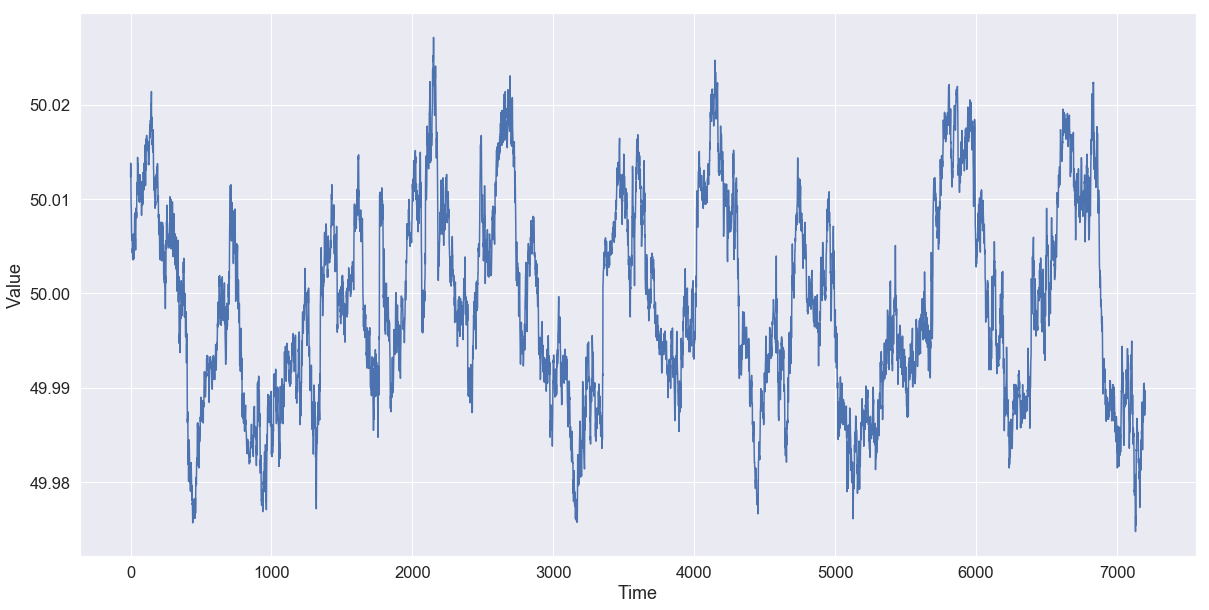

In [42]:
plt.plot(hmmds)
plt.xlabel("Time")
plt.ylabel("Value")

### Finding Hidden states using HMM

In [43]:
X = hmmds.values

models = {}

for i in range(2,7):
    models[i] = GaussianHMM(n_components=i, 
                            n_iter = 25,
                            covariance_type="full", 
                            algorithm='viterbi').fit(X)

model = models[components]



In [44]:


# Predict the optimal sequence of internal hidden state
hidden_states = model.predict(X)

pr("Means and vars of each hidden state")
for i in range(model.n_components):
    pr("{0}th hidden state".format(i))
    pr("mean = %s"% model.means_[i])
    pr("var = %s"% np.diag(model.covars_[i]))
    pr("std = %s"%np.diag(np.sqrt(model.covars_[i])))
    pr()

Means and vars of each hidden state
0th hidden state
mean = [50.00092407]
var = [1.43582453e-05]
std = [0.00378923]

1th hidden state
mean = [49.98563002]
var = [1.79782565e-05]
std = [0.00424008]

2th hidden state
mean = [50.01213694]
var = [2.43974804e-05]
std = [0.00493938]

3th hidden state
mean = [49.99332132]
var = [1.09197511e-05]
std = [0.0033045]



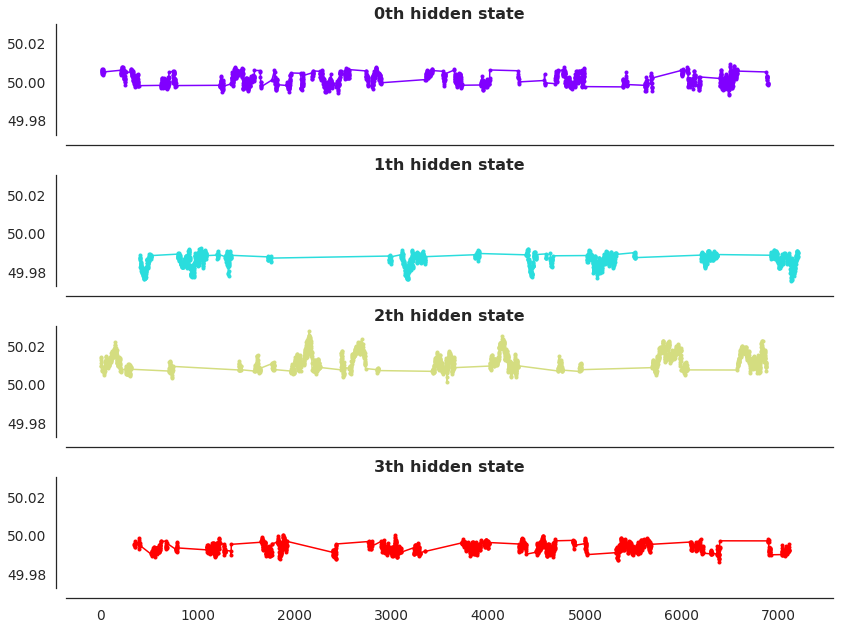

In [45]:
sns.set(font_scale=1.25)
style_kwds = {'xtick.major.size': 3, 'ytick.major.size': 3,
              'font.family':u'courier prime code', 'legend.frameon': True}
sns.set_style('white', style_kwds)

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(12,9))
colors = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, color) in enumerate(zip(axs, colors)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot(hmmds.index.values[mask],
                 hmmds.values[mask],
                 ".-", c=color)
    ax.set_title("{0}th hidden state".format(i), fontsize=16, fontweight='demi')

    # Format the ticks.
    sns.despine(offset=10)

plt.tight_layout()
fig.savefig('hidden_states_hmm_%s.png'%components)

In [46]:
sns.set(font_scale=1.5)
states = (pd.DataFrame(hidden_states, columns=['states'], index=hmmds.index)
          .join(hmmds, how='inner')
          .reset_index(drop=False).rename(columns={0:'values'}))

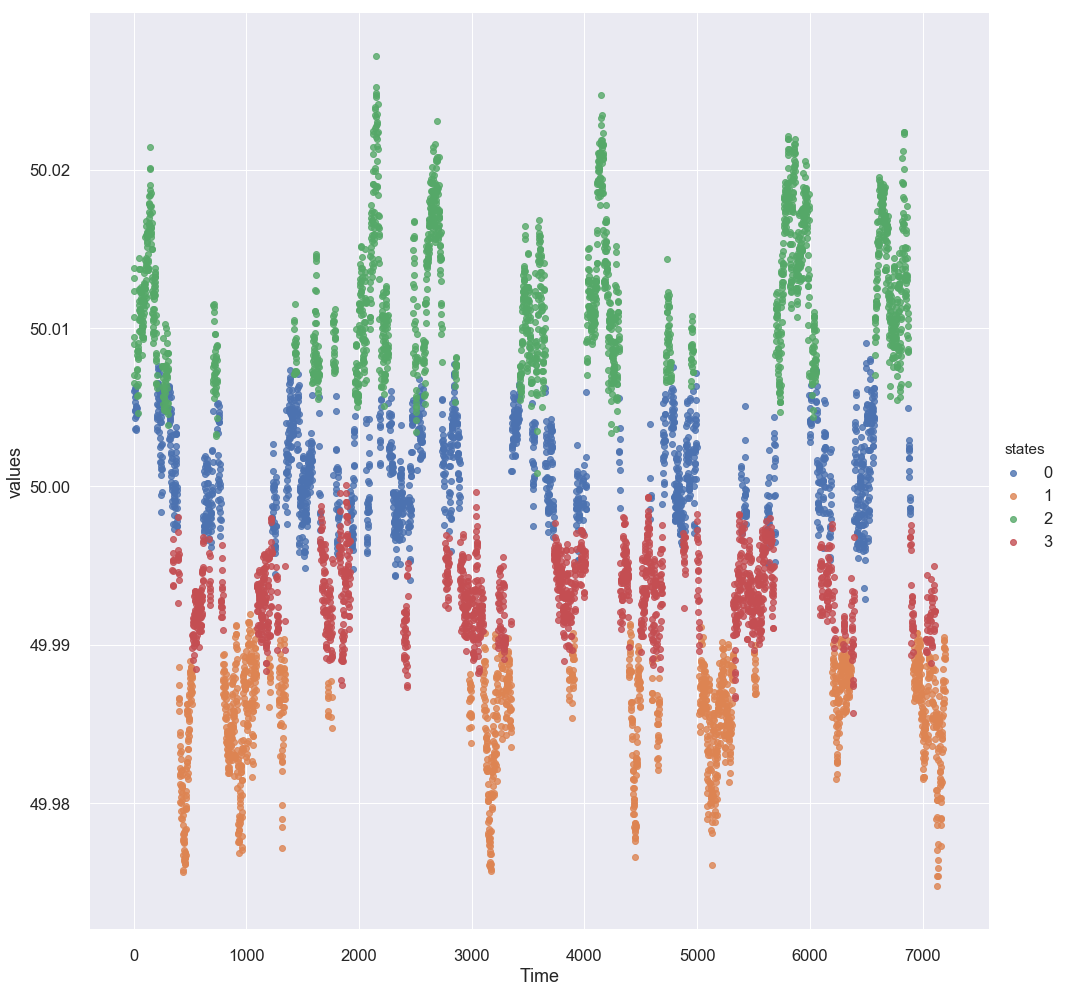

In [47]:
fg = sns.FacetGrid(data=states, hue='states',size=14)
fg.map(plt.scatter, 'index', 'values', alpha=0.8).add_legend()
plt.xlabel("Time")
sns.despine(offset=10)
# fg.savefig('states_img_hmm_%s.png'%components)

In [48]:
pr("Summary Statistics of each state for HMM")
pr(states.groupby(['states']).agg(['median','min','max'])[['values']])
pr()

Summary Statistics of each state for HMM
           values                      
           median        min        max
states                                 
0       50.000988  49.992908  50.009029
1       49.986237  49.974754  49.991974
2       50.011600  50.000832  50.027149
3       49.993240  49.985718  50.000088



#### Modes

In [49]:
pr("Mode of each state for HMM")
pr(states.groupby(['states']).agg(lambda x:x.value_counts().index[0])[['values']])

pr("Kurtosis of each state for HMM")
pr(states.groupby(['states']).agg(lambda x:kurtosis(x))[['values']])
pr()

pr("SignaltoNoise of each state for HMM")
pr(states.groupby(['states']).agg(lambda x:signaltonoise(x))[['values']])
pr()

Mode of each state for HMM
           values
states           
0       50.003246
1       49.986317
2       50.009132
3       49.993774
Kurtosis of each state for HMM
          values
states          
0      -0.895109
1       0.109138
2      -0.569437
3      -0.411187

SignaltoNoise of each state for HMM
              values
states              
0       17273.202062
1       14846.561480
2       11401.889104
3       22067.184033



#### States in time

<Figure size 2016x1008 with 0 Axes>

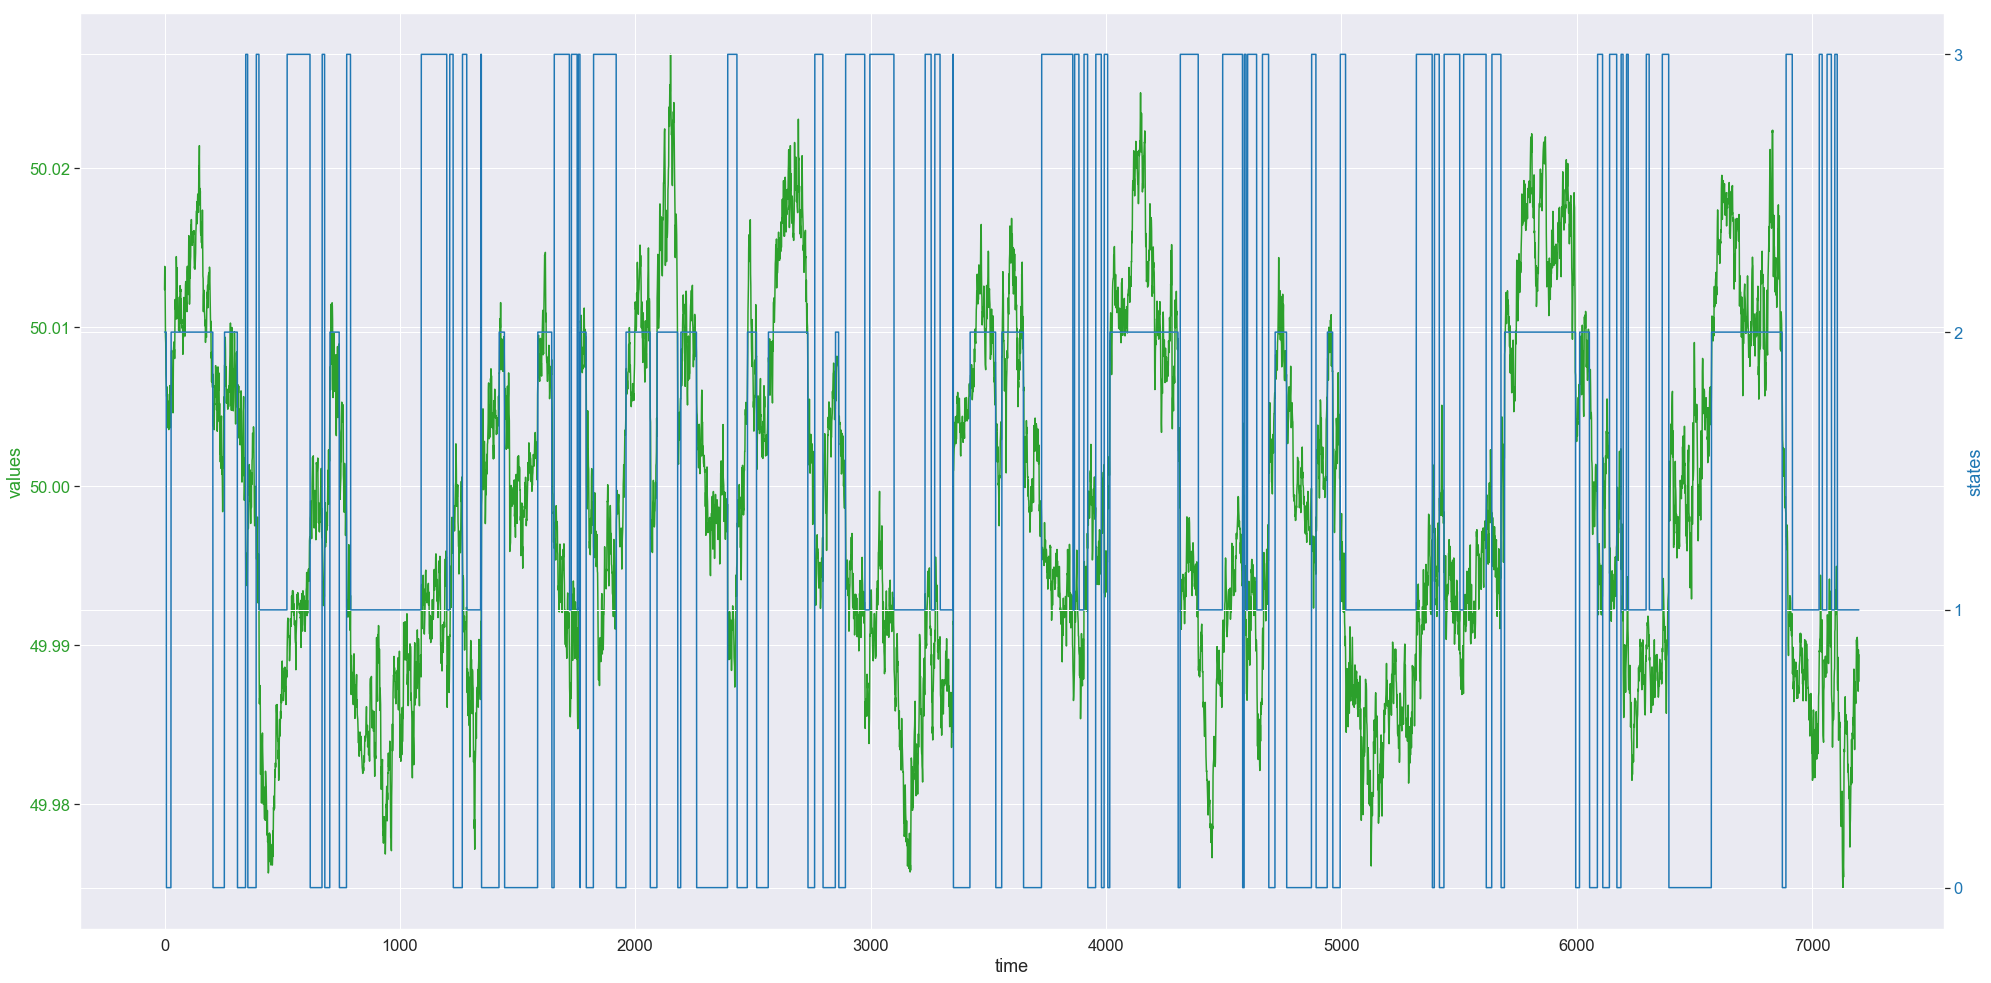

In [50]:
plt.figure(figsize=(28,14))
plt.rcParams["figure.figsize"] = (28,14)
fig, ax1 = plt.subplots()
data1 = states['values']
data2 = states['states']

t = states['index']
color = 'tab:green'
ax1.set_xlabel('time')
ax1.set_ylabel('values', color=color)
ax1.plot(t, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('states', color=color)  # we already handled the x-label with ax1
ax2.plot(t, data2, color=color) # or scatter
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks(list(range(components)))

fig.tight_layout()  # otherwise the right y-label is slightly clipped

plt.show()
fig.savefig('states_img_in_time_hmm_%s.png'%components)

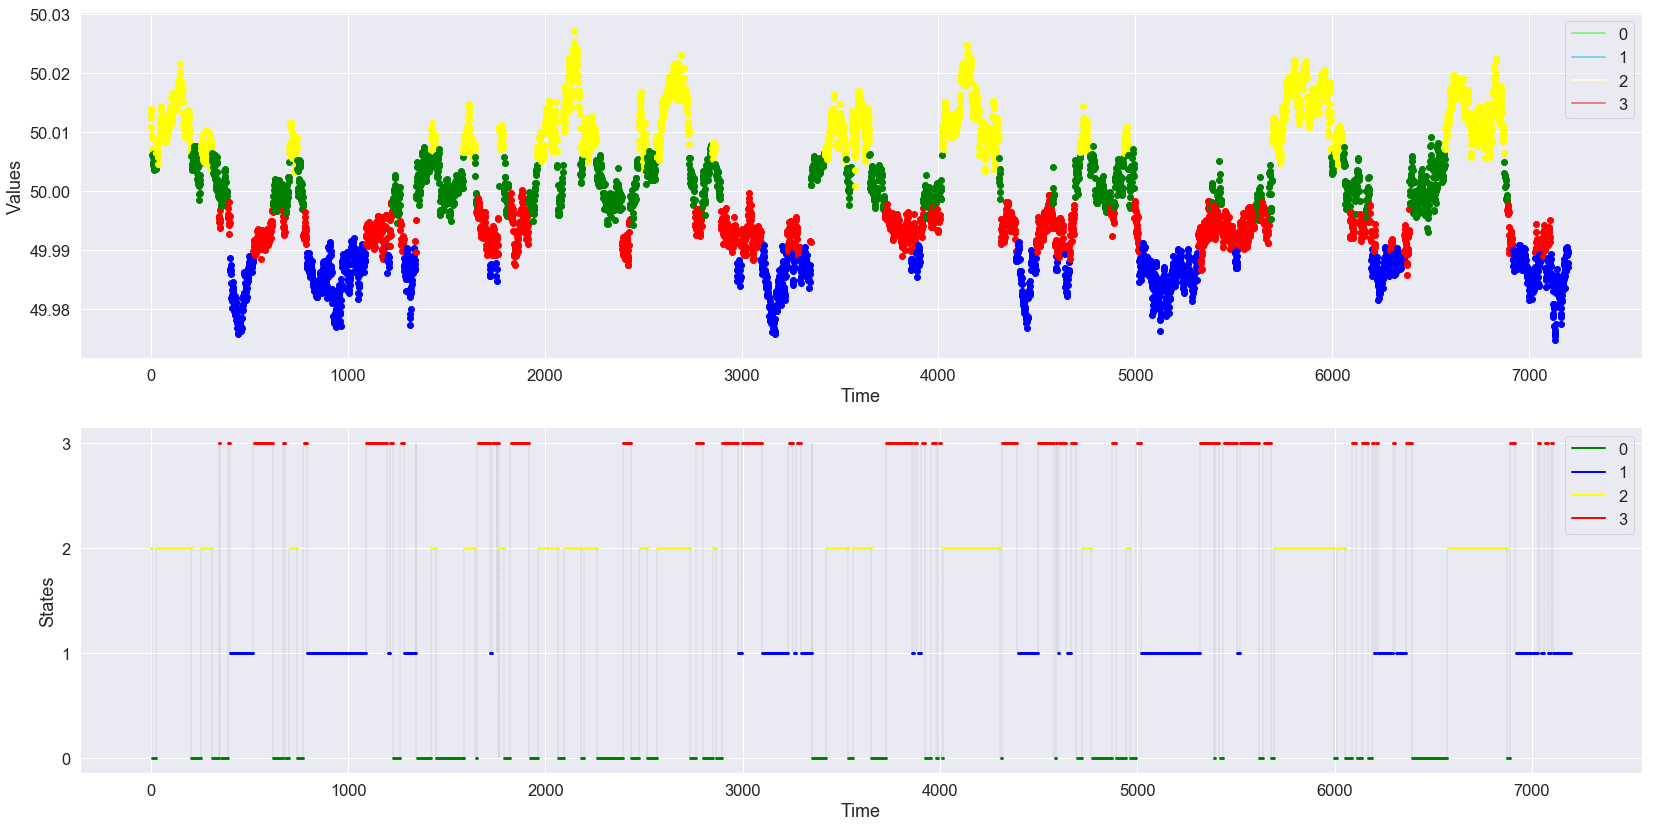

In [51]:
stt = states['states']
index = states['index']
values = states['values']
def uniqueish_color(state):
    sm = {0:"green",1:"blue",2:"yellow",3:"red",4:"purple",-1:"black",
         "0":"lightgreen","1":"skyblue","2":"cornsilk","3":"lightcoral","4":"thistle","-1":"black"} # this line for shades
    return sm[state]

from matplotlib.lines import Line2D

custom_lines = []
custom_lines_shades = []
for i in range(components):
    custom_lines.append(Line2D([0], [0], color=uniqueish_color(i), lw=2))
    custom_lines_shades.append(Line2D([0], [0], color=uniqueish_color(str(i)), lw=2))


fig, axes = plt.subplots(2)    
ax = axes[0]




#P1

i=0
while(i<len(index)):
    state = stt[i]
    ib = i
    next_state = state
    while(i<len(index) and stt[i]==state):
        i=i+1
        if i<len(index):
            next_state = stt[i]
    x=index[ib:i]
    y=values[ib:i]
    #ax.axvspan(ib, i-1, facecolor=uniqueish_color(str(state)), alpha=0.5)
    ax.scatter(x, y, color=uniqueish_color(state))
    
ax.legend(custom_lines_shades, range(components)) 
ax.set_xlabel("Time")
ax.set_ylabel("Values") 

#

# P2
ax = axes[1]

i=0
while(i<len(index)):
    state = stt[i]
    ib = i
    next_state = state
    while(i<len(index) and stt[i]==state):
        i=i+1
        if i<len(index):
            next_state = stt[i]
    x=(ib,i-1)
    y=(state,state)
    
    ax.plot(x, y, color=uniqueish_color(state),linewidth=3)
    
    
    
    x=(i-1,i-1)
    y=(state,next_state)
    ax.plot(x, y, color=uniqueish_color(-1),linewidth=0.2,ls='dotted')

ax.set_xlabel("Time")
ax.set_ylabel("States") 
ax.set_yticks(list(range(components)))
ax.legend(custom_lines, range(components),loc='upper right')
#


# Show
plt.show() 
fig.savefig('states_img_in_time_together_hmm_%s.png'%components)



- https://matplotlib.org/gallery/text_labels_and_annotations/custom_legends.html
- https://stackoverflow.com/questions/39500265/manually-add-legend-items-python-matplotlib
- https://stackoverflow.com/questions/17240694/python-how-to-plot-one-line-in-different-colors
- https://stackoverflow.com/questions/9957637/how-can-i-set-the-background-color-on-specific-areas-of-a-pyplot-figure
- https://matplotlib.org/examples/color/named_colors.html
- https://stackoverflow.com/questions/51413068/calculate-signal-to-noise-ratio-in-python-scipy-version-1-1